In [1]:
!pip install arviz

     |████████████████████████████████| 1.5 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 284 kB 17.0 MB/s eta 0:00:01


In [5]:
import arviz as az
#MCMC  の　可視化に利用

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns



import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

In [4]:
!pip install tensorflow_probability

     |████████████████████████████████| 4.3 MB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 9.3 MB/s  eta 0:00:01


In [6]:
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが1つだと明示するためaxisを追加　
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        #axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v  in zip(var_name, states)}
        # from_tfpもあるが、実行するとeager_executionがオフにされてしまうなど現状使いづらいので、from_dictを用いている
    return az.from_dict(trace)

In [7]:
def init_random(shape, n_chains=1, r=2):
    """f if if if if if if if if if if if if if if if if if if if if i
    Stanにならい、Uniform(-2, 2)で初期化する
    """
    
    if n_chains == 1:
        return tf.random.uniform(shape, -1, 1)
    else:
        return tf.random.uniform([n_chains,] + shape, -r, r)

In [8]:
#標準正規分布
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


<AxesSubplot:>

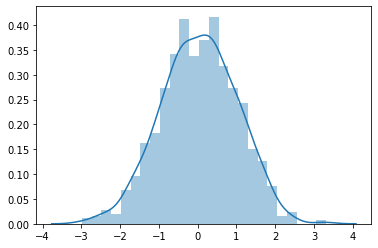

In [10]:
samples = normal.sample(1000)
sns.distplot(samples)

In [11]:
#log prob メソッド
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [15]:
#線形ガウス状態空間モデル

ndims = 2
step_std = 1.0
noise_std = 5.0


model = tfd.LinearGaussianStateSpaceModel(
    num_timesteps=100,
    transition_matrix=tf.linalg.LinearOperatorIdentity(ndims),
    transition_noise=tfd.MultivariateNormalDiag(
    scale_diag = step_std**2 *tf.ones([ndims])),
    observation_matrix = tf.linalg.LinearOperatorIdentity(ndims),
    observation_noise = tfd.MultivariateNormalDiag(
    scale_diag=noise_std**2 * tf.ones([ndims])),
    initial_state_prior = tfd.MultivariateNormalDiag(
    scale_diag = tf.ones([ndims])))

Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


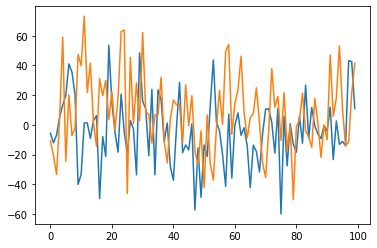

In [16]:
#100時点分の2次元の観測値が確率分布(モデル)からの１つのサンプルとなる
y = model.sample()
for i in range(ndims):
    plt.plot(y[:, i])

<class 'tensorflow_probability.python.distributions.transformed_distribution.TransformedDistribution'>


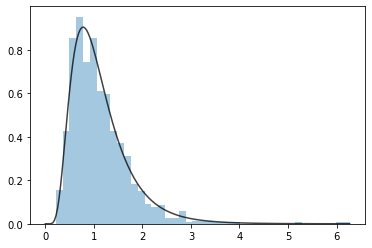

In [22]:
exp_bijector = tfp.bijectors.Exp()
#変数変換したdistribution
log_normal = exp_bijector(tfd.Normal(0., .5,))
print(type(log_normal))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c="k", alpha=.75)

<class 'tensorflow_probability.python.distributions.transformed_distribution.TransformedDistribution'>


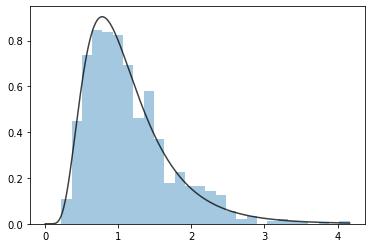

In [24]:
#等価な書き方

log_normal = tfd.TransformedDistribution(
    distribution=tfd.Normal(0., .5),
    bijector=tfp.bijectors.Exp()
)

print(type(log_normal))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c="k", alpha=.75)

In [26]:
#パラメータのリストを渡すことで、異なる２つの正規分布をまとめて表現できる
#この場合、batch shape になる

normal = tfd.Normal(loc=[-1., 1.], scale=[1., 1.5])
#batch 2, Event : []
print(normal)


# sample shapeは一番左(外側)のaxisに追加される
print('shape of sampled Tensor:', normal.sample(10).shape) # Sample: 10, Batch: 2, Event: 

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32)
shape of sampled Tensor: (10, 2)


In [27]:
# 二変量正規分布
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [30]:
normals = tfd.Normal(loc=[-1., 1.], scale=1.) 
normals_ind = tfd.Independent(normals, reinterpreted_batch_ndims=1)
# 対数確率を評価してみる。tfd.Independentよりevent　shapeに変換された次元については、対数確率を評価する際にreduce_sumされる。
s = normal.sample()
tf.assert_equal(tf.reduce_sum(normals.log_prob(s)), normals_ind.log_prob(s))

In [32]:
#同一なサンプルから独立のサンプルを抽出

bernoulli = tfd.Bernoulli(probs=0.5)
bernoulli_sample = tfd.Sample(bernoulli, sample_shape=10)
print(bernoulli_sample)

tfp.distributions.Sample("SampleBernoulli", batch_shape=[], event_shape=[10], dtype=int32)


In [34]:
s = bernoulli_sample.sample()
bernoulli_sample.log_prob(s)

<tf.Tensor: shape=(), dtype=float32, numpy=-6.931472>

Text(0.5, 1.0, 'Histogram of ovserved data')

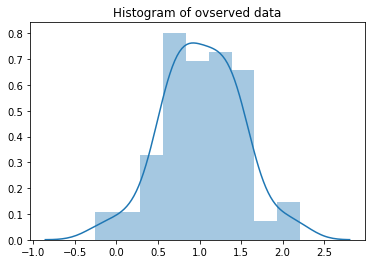

In [40]:
#正規分布のせパラメーターの推定

mu_true, sigma_true = 1.0, 0.5
n_sample = 100

normal = tfd.Normal(loc=mu_true, scale=sigma_true)
data = normal.sample(n_sample)


sns.distplot(data)
plt.title("Histogram of ovserved data")

In [50]:
#事前分布はRoot でラップする
Root = tfd.JointDistributionCoroutine.Root

def model():
    mu = yield Root(tfd.Normal(loc=0, scale=10))
    #平均mu の事前分布
    sigma = yield Root(tfd.HalfCauchy(loc=0, scale=5))
    #標準偏差sigmaの事前分布

    #全データ点について、対数確率の和を取りたいため、tfd.sample で　event shapeをn_sample にする
    #他のパラメーター（この場合mu 、sigma）に条件付けられた確率分布はRoot でラップしなくて良い
    y = yield tfd.Sample(tfd.Normal(loc=mu, scale=sigma), n_sample)

joint = tfd.JointDistributionCoroutine(model)
print(type(joint))

<class 'tensorflow_probability.python.distributions.joint_distribution_coroutine.JointDistributionCoroutine'>


In [51]:
mu_sample, sigma_sample, y_sample = joint.sample(5)
#mu , y

print(joint.log_prob(mu_sample, sigma_sample, y_sample))
# 対数同時確率

tf.Tensor([-170.56311 -328.32028 -195.23033 -328.3837  -280.0418 ], shape=(5,), dtype=float32)


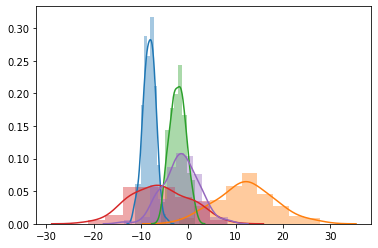

In [52]:
#設定した事前分布をサンプリングしてみる

for i in y_sample:
    sns.distplot(i)

In [59]:
#　y が与えられた元での、mu, sigma(正規化されていない)事後確率を返す関数
def unnormalized_log_posterior(mu, sigma):
    return joint.log_prob(mu, sigma, data)
# 観測データを与える

In [62]:
"""
MCMCの詳細な設定

・サンプリング数 (num_results) : 事後分布からのサンプルをいくつ取得するか
・バーンイン期間(num_burnin_steps) : MCMCがまだ収束していないと判断し、捨てるサンプルの数
・パラメーターの初期値(current_state) : 適当な値を設定
・遷移核（kernel）：MCMCのアルゴリズム 

ハミルトニアン・モンテカルロ法

"""

num_results = 4000
num_burnin_steps = 1000

#パラメーターの初期値

current_state = [
    tf.ones([], name="init_mu"),
    tf.ones([], name="init_sigma")
]


#ハミルトニアン・モンテカルロ法を用いる。step size というハイパーパラメータの調整が必要になるが
#Simple Step Size Adaptation でラップすることで、自動的に調整してくれる

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalized_log_posterior,
        step_size=0.1,
        num_leapfrog_steps=5),
    num_adaptation_steps=int(num_burnin_steps*0.8)
)


#tf.fuction でデコレートすることで、計算グラフがコンパイルされ、高速に実行される
@tf.function(autograph=False, experimental_compile=True)
def do_sampling(num_results, num_burnin_steps, current_state, kernel):
    return tfp.mcmc.sample_chain(
        num_results = num_results,
        num_burnin_steps=num_burnin_steps,
        current_state = current_state,
        kernel = kernel
    )


states,kernel_results = do_sampling(num_results, num_burnin_steps, current_state, kernel)
accept_rate = kernel_results.inner_results.is_accepted.numpy().mean(axis=0)

print("Acceptance rate : {:.1%}".format(accept_rate))

/Users/imutayuji/opt/anaconda3/envs/brave/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate : 64.5%


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

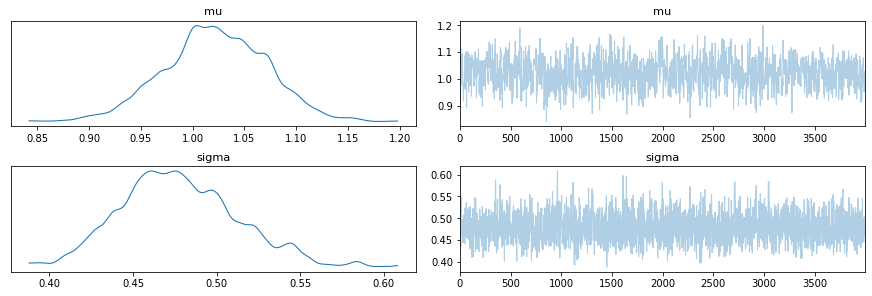

In [63]:
var_name = ["mu", "sigma"]
trace = format_trace(states, var_name)
az.plot_trace(trace)

In [64]:
az.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.022,0.049,0.927,1.108,0.002,0.001,912.0,911.0,912.0,1261.0,NaN
sigma,0.478,0.035,0.419,0.547,0.001,0.001,1319.0,1293.0,1340.0,909.0,NaN


In [69]:
n_chains = 3

current_state = [tf.random.uniform([n_chains], -2, 2, name="init_mu"),
                               tf.random.uniform([n_chains], 1, 4, name="init_sigma")]

states, kernel_results = do_sampling(num_results, num_burnin_steps, current_state, kernel)

accept_rate = kernel_results.inner_results.is_accepted.numpy().mean(axis=0)
print('Acceptance rate: {:.1%}, {:.1%}, {:.1%}'.format(*accept_rate))

Acceptance rate: 87.6%, 87.8%, 86.6%


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.021,0.047,0.934,1.11,0.000,0.000,18040.0,18011.0,17997.0,5894.0,1.00
sigma,0.474,0.032,0.414,0.53,0.004,0.003,73.0,71.0,75.0,84.0,1.01


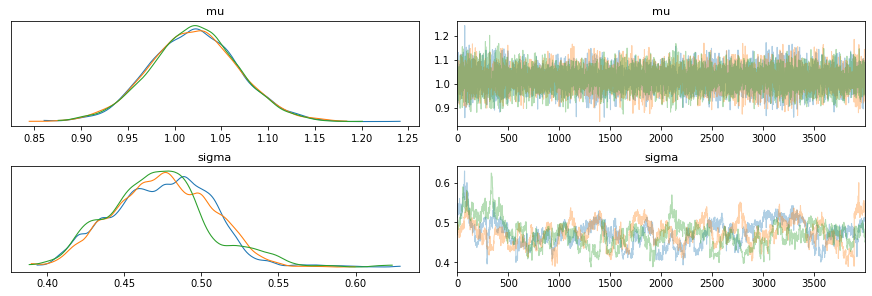

In [70]:
var_name = ["mu", "sigma"]
trace = format_trace(states, var_name, chain_dim=1)
az.plot_trace(trace)
az.summary(trace)